# Comparing AFSK with APSK

**AFSK**: Frequency Shift Keying over Audio FM

**APSK**: Phase Shift Keying over Audio FM

Which is "better"?

In [1]:
import numpy as np
from scipy.signal import lfilter, firwin, decimate
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)

In [2]:
sr = 2e6
bd = 2000
sr_bb = 40e3
np.random.seed(0)
bits = np.random.randint(0, 2, 2000) * 2 - 1

In [3]:
def plot_bb(sig, sr, sr_bb):
    plt.figure()
    plt.specgram(sig[::sr/sr_bb], Fs=sr_bb)
    plt.figure()
    plt.psd(sig[::sr/sr_bb], Fs=sr_bb)
    plt.figure()
    plt.plot(sig[sr/bd:6*sr/bd])

def plot_pb(sig, sr, centre):
    plt.figure()
    plt.specgram(sig, Fs=sr, NFFT=1024, noverlap=512)
    plt.figure()
    plt.psd(sig, Fs=sr, NFFT=2048, noverlap=512)
    plt.xlim(centre - 1e5, centre + 1e5)

## Baseband Modulation

### FSK Modulation

In [4]:
def mod_fsk(bits, bd, sr, sr_bb, centre, dev):
    bitfreqs = [centre + bit * dev for bit in bits]
    freqs = np.repeat(bitfreqs, sr/bd)
    return np.sin(2*np.pi*np.cumsum(freqs)/sr)

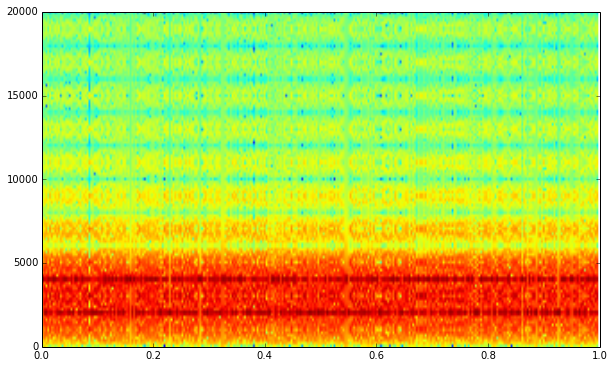

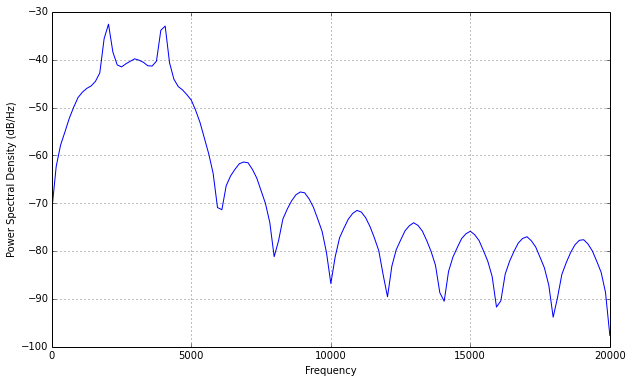

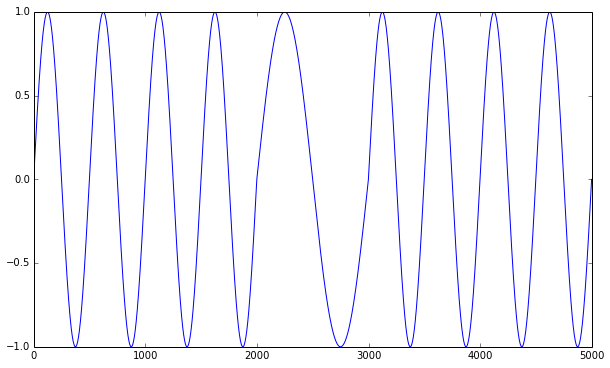

In [5]:
fsk_signal = mod_fsk(bits, bd, sr, sr_bb, centre=3000, dev=1000)
plot_bb(fsk_signal, sr, sr_bb)

### PSK Modulation
Now we try a PSK waveform, with the centre freq the average of the two FSK frequencies, again 50bd data at 8ksps.

In [6]:
def mod_psk(bits, bd, sr, sr_bb, centre):
    bitphases = np.repeat(bits, int(sr/bd))
    carrierfreqs = np.repeat([centre], bitphases.size)
    carrierphases = 2 * np.pi * np.cumsum(carrierfreqs)
    phases = carrierphases * bitphases
    return np.sin(phases/sr)

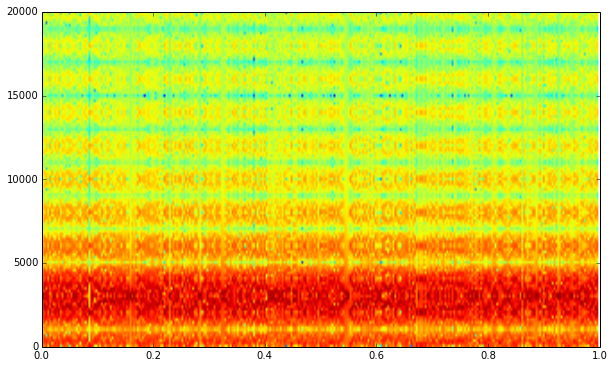

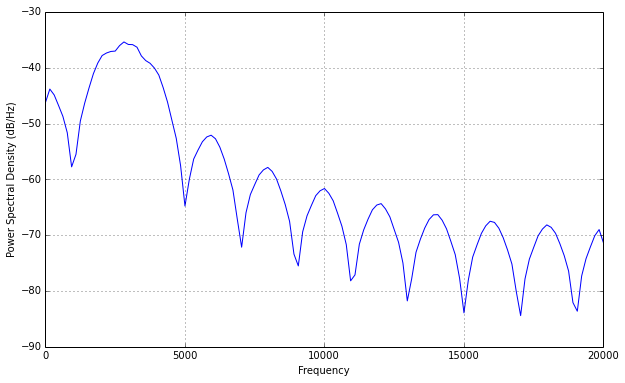

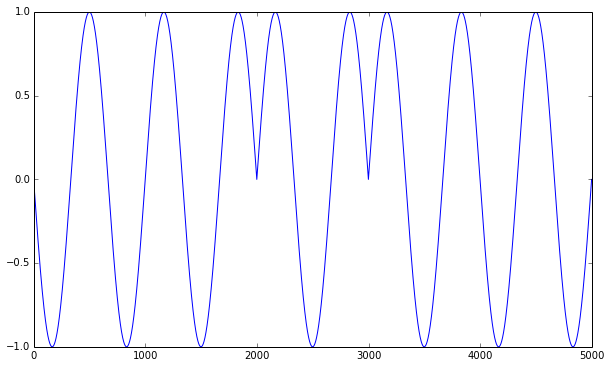

In [7]:
psk_signal = mod_psk(bits, bd, sr, sr_bb, centre=3000)
plot_bb(psk_signal, sr, sr_bb)

Evidently PSK has better bandwidth characteristics (as it happens, it's a better choice for bandwidth limited applications whereas FSK makes more sense for power limited applications, though in general BPSK will be superior to BFSK).

However, we have to modulate over FM. So how does that look?

## Passband

In [8]:
def mod_fm(sig, sr, centre, dev):
    freqs = centre + dev * sig
    return np.sin(2*np.pi*np.cumsum(freqs)/sr)

### AFSK Modulation
We'll modulate the FSK signal onto an FM carrier.

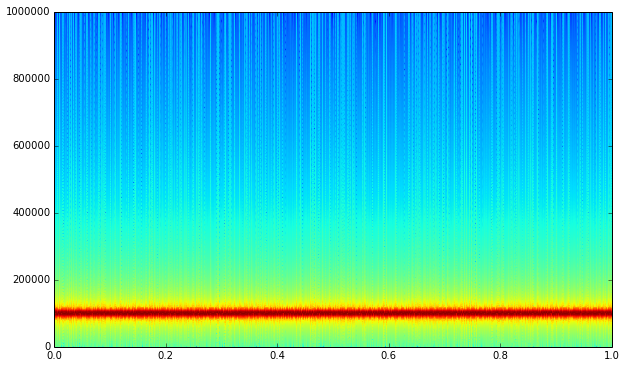

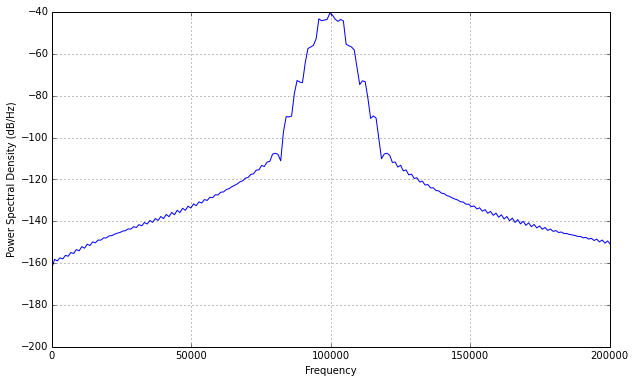

In [9]:
afsk_signal = mod_fm(fsk_signal, sr, centre=sr/20, dev=4000)
plot_pb(afsk_signal, sr, sr/20)

### APSK Modulation
Same thing, PSK.

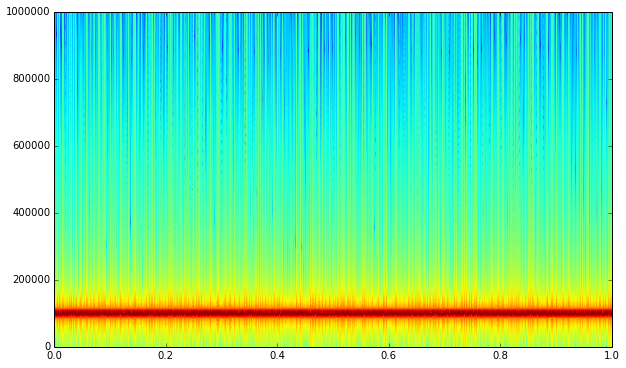

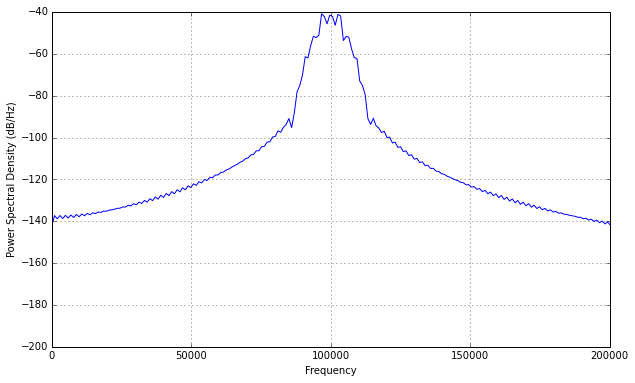

In [10]:
apsk_signal = mod_fm(psk_signal, sr, centre=sr/20, dev=4000)
plot_pb(apsk_signal, sr, sr/20)

### FM Demodulation

In [258]:
def demod_fm(sig, n_bits, bd, sr, centre, dev):
    h = firwin(32, 3*(dev+6000), nyq=sr/2)
    t = np.linspace(0.0, n_bits/bd, sig.size)
    lo_i = np.sin(2*np.pi*t*centre)
    lo_q = np.cos(2*np.pi*t*centre)
    sig_i = lfilter(h, 1, lo_i * sig)
    sig_q = lfilter(h, 1, lo_q * sig)
    phase = np.unwrap(np.arctan2(sig_q, sig_i))
    dphase = np.diff(phase)
    return lfilter(h, 1, dphase) * 80

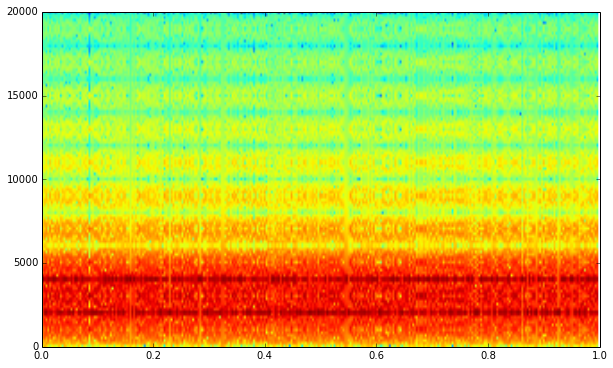

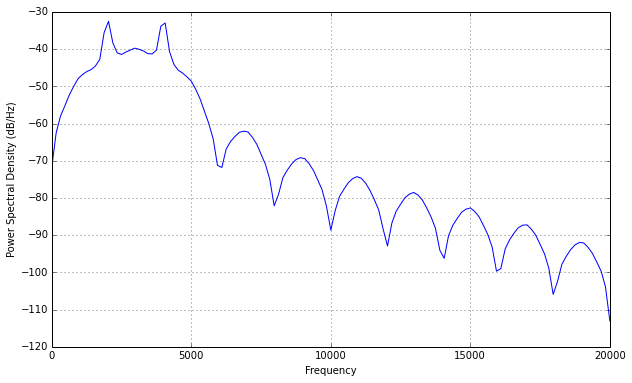

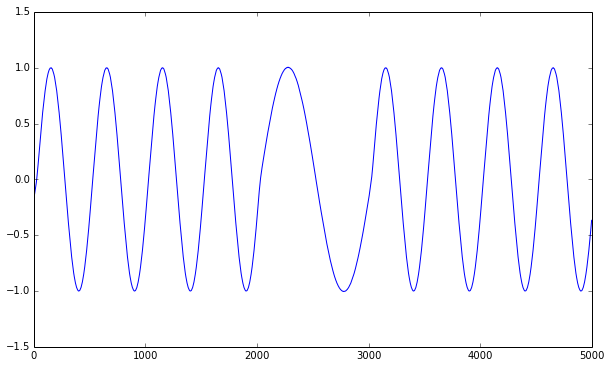

In [259]:
fsk_signal_out = demod_fm(afsk_signal, len(bits), bd,
                          sr, centre=sr/20, dev=4000)
plot_bb(fsk_signal_out, sr, sr_bb)

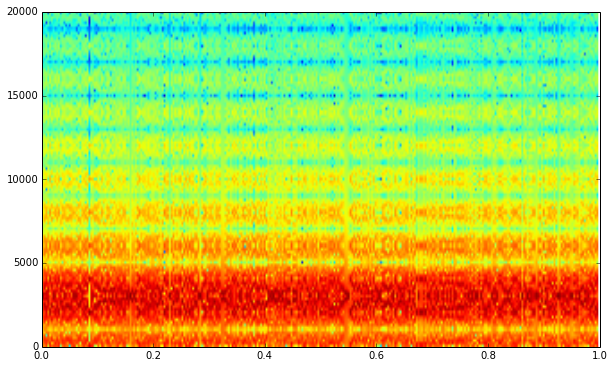

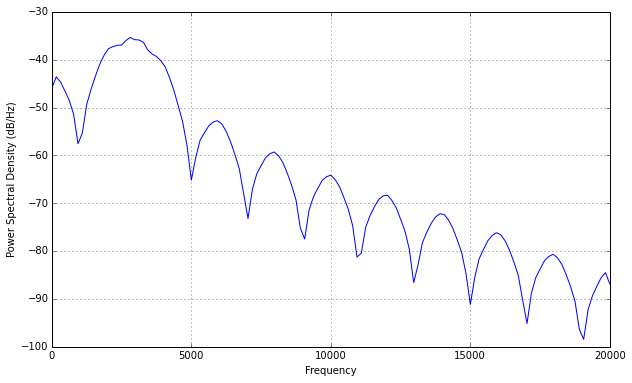

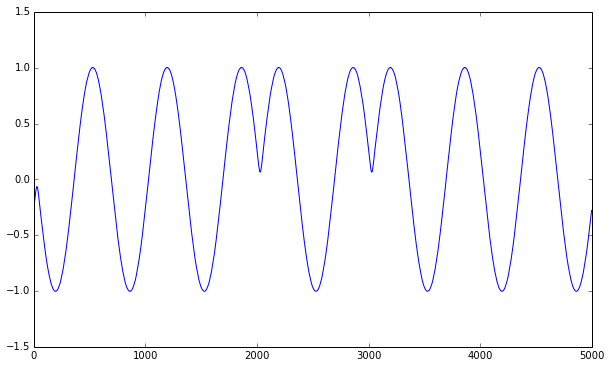

In [260]:
psk_signal_out = demod_fm(apsk_signal, len(bits), bd,
                          sr, centre=sr/20, dev=4000)
plot_bb(psk_signal_out, sr, sr_bb)

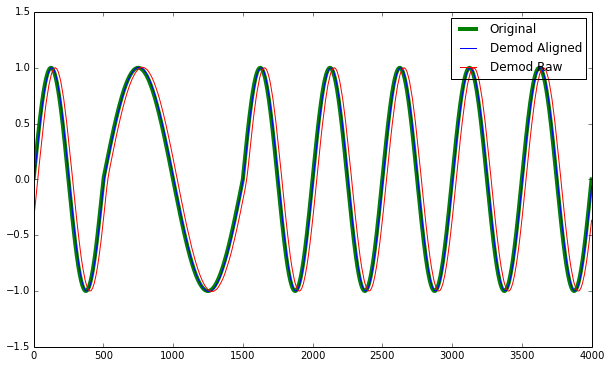

In [261]:
plt.plot(fsk_signal[2500:6500], lw=4, color='g', label="Original")
plt.plot(fsk_signal_out[2525:6525], lw=1, color='b', label="Demod Aligned")
plt.plot(fsk_signal_out[2500:6500], color='r', label="Demod Raw")
plt.legend()
None

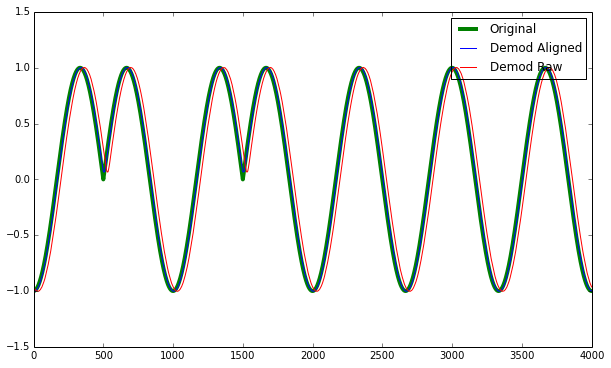

In [262]:
plt.plot(psk_signal[2500:6500], lw=4, color='g', label="Original")
plt.plot(psk_signal_out[2525:6525], lw=1, color='b', label="Demod Aligned")
plt.plot(psk_signal_out[2500:6500], color='r', label="Demod Raw")
plt.legend()
None

So, with no noise we can recover the modulated FM signal quite effectively. Great!

## Baseband Demodulation

In [ ]:
def make_rcf(bd, sr):
    b = 0.5
    w = 3
    x = np.linspace(-w/bd, w/bd, sr/bd * 2 * w)
    rcf = np.sin(np.pi * x * bd) / (np.pi * x * bd)
    rcf *= np.cos(np.pi * b * x * bd)
    rcf /= (1 - (2 * b * x * bd)**2)
    return rcf

### FSK Demodulation

In [226]:
def demod_fsk(sig, n_bits, bd, sr, sr_bb, centre, dev, plot=False):
    sigf = decimate(sig, int(sr/sr_bb))
    sigf = np.hstack((sigf, np.zeros(3 * sr_bb/bd)))
    t = np.linspace(0.0, n_bits/bd, sigf.size)
    lo_mark_i = np.sin(2*np.pi*(centre+dev)*t)
    lo_mark_q = np.cos(2*np.pi*(centre+dev)*t)
    lo_space_i = np.sin(2*np.pi*(centre-dev)*t)
    lo_space_q = np.cos(2*np.pi*(centre-dev)*t)
    rcf = make_rcf(bd, sr_bb)
    sig_mark_i = lfilter(rcf, 1, sigf * lo_mark_i) ** 2
    sig_mark_q = lfilter(rcf, 1, sigf * lo_mark_q) ** 2
    sig_space_i = lfilter(rcf, 1, sigf * lo_space_i) ** 2
    sig_space_q = lfilter(rcf, 1, sigf * lo_space_q) ** 2
    mark = sig_mark_i + sig_mark_q
    space = sig_space_i + sig_space_q
    det = mark - space
    if plot:
        plt.figure()
        plt.plot(t[3*20+10:800], det[3*20+10:800], color='b')
        plt.axhline(0, color='k')
        plt.scatter(t[3*20+10:800:20], det[3*20+10:800:20])
    bits = (det[(sr_bb/bd)/2::sr_bb/bd] > 0)[3:] * 2 - 1
    return bits

True

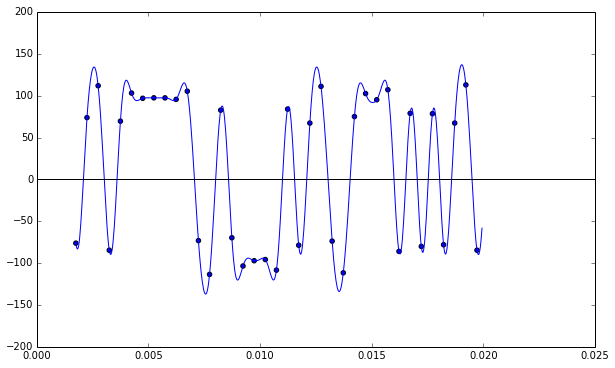

In [263]:
fsk_bits = demod_fsk(fsk_signal_out, len(bits), bd,
                     sr, sr_bb, centre=3000, dev=1000, plot=True)
np.all(fsk_bits == bits)

### PSK Demodulation

In [224]:
def demod_psk(sig, n_bits, bd, sr, sr_bb, centre, plot=False):
    sigf = decimate(sig, int(sr/sr_bb))
    sigf = np.hstack((sigf, np.zeros(3 * sr_bb/bd)))
    rcf = make_rcf(bd, sr_bb)
    t = np.linspace(0.0, n_bits/bd, sigf.size)
    carrierfreqs = np.repeat([centre], (n_bits + 3) * sr_bb / bd)
    carrierphase = np.cumsum(carrierfreqs) / sr_bb
    lo_i = np.cos(2*np.pi*carrierphase - 0.336)
    lo_q = np.sin(2*np.pi*carrierphase - 0.336)
    sig_i = lfilter(rcf, 1, lo_i * sigf)
    sig_q = lfilter(rcf, 1, lo_q * sigf)
    if plot:
        plt.figure()
        plt.plot(sig_i[3*20+10:], sig_q[3*20+10:], color='k', lw=0.01)
        plt.scatter(sig_i[3*20+10::20], sig_q[3*20+10::20], s=50)
        plt.axvline(0.0, color='k')
        plt.grid()
    bits = (sig_i[(sr_bb/bd)/2::sr_bb/bd] < 0)[3:] * 2 - 1
    return bits

True

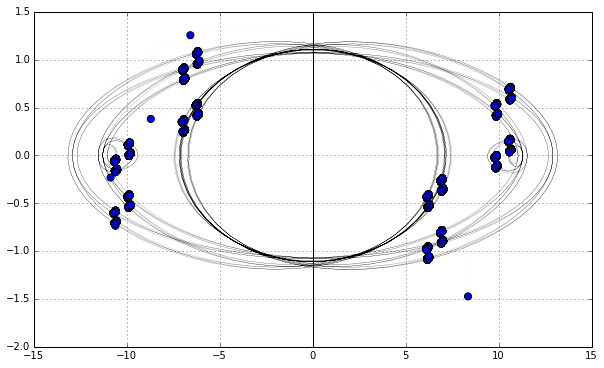

In [264]:
psk_bits = demod_psk(psk_signal_out, len(bits), bd,
                     sr, sr_bb, centre=3000, plot=True)
np.all(psk_bits == bits)

## Channel Simulation

In [298]:
def run_sim(ebnodb, bd, sr, sr_bb, seed=0):
    print("Eb/N0 = {:02}dB\tRepeat = {}\t".format(ebnodb, seed),
          end='', flush=True)
    ebno = 10.0**(ebnodb/10.0)
    np.random.seed(seed)
    bits = np.random.randint(0, 2, 2000) * 2 - 1
    fsk_signal = mod_fsk(bits, bd, sr, sr_bb, centre=3000, dev=1000)
    psk_signal = mod_psk(bits, bd, sr, sr_bb, centre=3000)
    afsk_signal = mod_fm(fsk_signal, sr, centre=sr/20, dev=4000)
    apsk_signal = mod_fm(psk_signal, sr, centre=sr/20, dev=4000)
    afsk_eb = np.var(afsk_signal) / bd
    apsk_eb = np.var(apsk_signal) / bd
    afsk_sigma = np.sqrt((sr/2) * afsk_eb / ebno)
    apsk_sigma = np.sqrt((sr/2) * apsk_eb / ebno)
    noise = np.random.randn(afsk_signal.size)
    afsk_signal += noise * afsk_sigma
    apsk_signal += noise * apsk_sigma
    fsk_signal_out = demod_fm(afsk_signal, len(bits), bd,
                          sr, centre=sr/20, dev=4000)
    psk_signal_out = demod_fm(apsk_signal, len(bits), bd,
                          sr, centre=sr/20, dev=4000)
    fsk_bits = demod_fsk(fsk_signal_out, len(bits), bd,
                         sr, sr_bb, centre=3000, dev=1000)
    psk_bits = demod_psk(psk_signal_out, len(bits), bd,
                         sr, sr_bb, centre=3000)
    fsk_ber = np.sum(fsk_bits != bits) / len(bits)
    psk_ber = np.sum(psk_bits != bits) / len(bits)
    print("FSK: {:.02e}, PSK: {:.02e}".format(fsk_ber, psk_ber))
    return fsk_ber, psk_ber

In [299]:
run_sim(15, bd, sr, sr_bb)

Eb/N0 = 15dB	Repeat = 0	FSK: 4.74e-01, PSK: 3.50e-01


(0.47399999999999998, 0.34999999999999998)

In [308]:
snrs = np.arange(10, 35, 2)
repeats = np.arange(10)
fsk_results = np.empty((snrs.size, repeats.size))
psk_results = np.empty((snrs.size, repeats.size))
for ridx, repeat in enumerate(repeats):
    for sidx, snr in enumerate(snrs):
        fsk, psk = run_sim(snr, bd, sr, sr_bb, seed=repeat)
        fsk_results[sidx][ridx] = fsk
        psk_results[sidx][ridx] = psk

Eb/N0 = 10dB	Repeat = 0	FSK: 5.19e-01, PSK: 4.82e-01
Eb/N0 = 12dB	Repeat = 0	FSK: 5.00e-01, PSK: 4.29e-01
Eb/N0 = 14dB	Repeat = 0	FSK: 5.00e-01, PSK: 3.82e-01
Eb/N0 = 16dB	Repeat = 0	FSK: 4.67e-01, PSK: 3.24e-01
Eb/N0 = 18dB	Repeat = 0	FSK: 3.74e-01, PSK: 2.20e-01
Eb/N0 = 20dB	Repeat = 0	FSK: 2.07e-01, PSK: 8.95e-02
Eb/N0 = 22dB	Repeat = 0	FSK: 6.35e-02, PSK: 2.45e-02
Eb/N0 = 24dB	Repeat = 0	FSK: 6.00e-03, PSK: 1.00e-03
Eb/N0 = 26dB	Repeat = 0	FSK: 5.00e-04, PSK: 0.00e+00
Eb/N0 = 28dB	Repeat = 0	FSK: 0.00e+00, PSK: 0.00e+00
Eb/N0 = 30dB	Repeat = 0	FSK: 0.00e+00, PSK: 0.00e+00
Eb/N0 = 32dB	Repeat = 0	FSK: 0.00e+00, PSK: 0.00e+00
Eb/N0 = 34dB	Repeat = 0	FSK: 0.00e+00, PSK: 0.00e+00
Eb/N0 = 10dB	Repeat = 1	FSK: 4.83e-01, PSK: 4.66e-01
Eb/N0 = 12dB	Repeat = 1	FSK: 4.98e-01, PSK: 4.32e-01
Eb/N0 = 14dB	Repeat = 1	FSK: 4.71e-01, PSK: 3.79e-01
Eb/N0 = 16dB	Repeat = 1	FSK: 4.54e-01, PSK: 3.12e-01
Eb/N0 = 18dB	Repeat = 1	FSK: 3.49e-01, PSK: 1.73e-01
Eb/N0 = 20dB	Repeat = 1	FSK: 1.99e-01, PSK: 8.

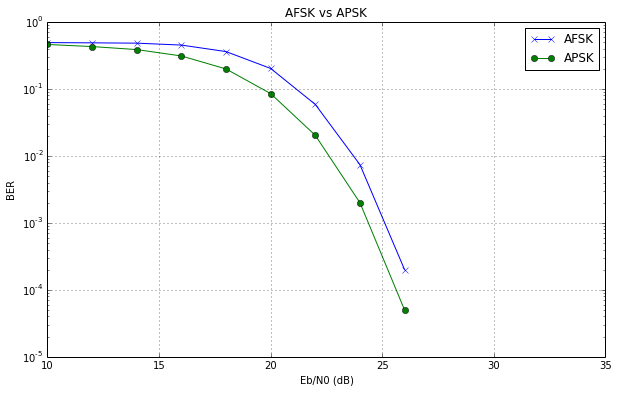

In [311]:
plt.plot(snrs, np.mean(fsk_results, axis=1), "x-", label="AFSK")
plt.plot(snrs, np.mean(psk_results, axis=1), "o-", label="APSK")
plt.semilogy()
plt.title("AFSK vs APSK")
plt.legend()
plt.grid()
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")